# Project: NYC Citi Bike Dataset

## Table of Contents

- <a href="#intro">Introduction and Wrangling</a>
- <a href="#eda">Exploration and Questions</a>
>- <a href="#1">Question 1</a>
>- <a href="#2">Question 2</a>
>- <a href="#3">Question 3</a>


<a id='intro'></a>
## Introduction and Wrangling

The data used in this project is open NYC Citi Bike dataset for August 2019. This dataset contains info about the trips of their bike rental stations such as trip time, start and end stations, station locations, bike used, and user demographics.

Let's first start by importing and viewing the data.

In [1]:
#importing the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
import zipfile
with zipfile.ZipFile('201908-citibike-tripdata.csv.zip', 'r') as zip:
    zip.extractall()

In [3]:
#reading the data into a Pandas DataFrame
df = pd.read_csv('201908-citibike-tripdata.csv')
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,393,2019-08-01 00:00:01.4680,2019-08-01 00:06:35.3780,531.0,Forsyth St & Broome St,40.718939,-73.992663,408.0,Market St & Cherry St,40.710762,-73.994004,35305,Subscriber,1996,2
1,627,2019-08-01 00:00:01.9290,2019-08-01 00:10:29.7840,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,3409.0,Bergen St & Smith St,40.686744,-73.990632,38822,Subscriber,1998,2
2,1132,2019-08-01 00:00:04.0480,2019-08-01 00:18:56.1650,2000.0,Front St & Washington St,40.702551,-73.989402,3388.0,President St & Henry St,40.682800,-73.999904,18373,Subscriber,1988,1
3,1780,2019-08-01 00:00:04.1630,2019-08-01 00:29:44.7940,479.0,9 Ave & W 45 St,40.760193,-73.991255,473.0,Rivington St & Chrystie St,40.721101,-73.991925,25002,Subscriber,1988,1
4,1517,2019-08-01 00:00:05.4580,2019-08-01 00:25:23.4550,3312.0,1 Ave & E 94 St,40.781721,-73.945940,3312.0,1 Ave & E 94 St,40.781721,-73.945940,31198,Subscriber,1965,2


- *Note: more info on the data could be found via this [link](https://www.citibikenyc.com/system-data).*

In [4]:
#viewing df info such as column headers, row count and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344224 entries, 0 to 2344223
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         float64
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           float64
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  birth year               int64  
 14  gender                   int64  
dtypes: float64(6), int64(4), object(5)
memory usage: 268.3+ MB


In [5]:
#ensuring there are no duplicated rows
df.duplicated().sum()

0

In [6]:
#looking for null values in each column
df.isnull().sum()

tripduration                0
starttime                   0
stoptime                    0
start station id           89
start station name         89
start station latitude      0
start station longitude     0
end station id             89
end station name           89
end station latitude        0
end station longitude       0
bikeid                      0
usertype                    0
birth year                  0
gender                      0
dtype: int64

In [7]:
#looks like we do have nulls, so first let's make sure the 89 across all 4 columns are coming from the same rows
df[df['start station id'].isnull()].isnull().sum()

tripduration                0
starttime                   0
stoptime                    0
start station id           89
start station name         89
start station latitude      0
start station longitude     0
end station id             89
end station name           89
end station latitude        0
end station longitude       0
bikeid                      0
usertype                    0
birth year                  0
gender                      0
dtype: int64

In [8]:
#dropping all 89 rows with null values in the station info, index is reset so it's sequence can be maintained
df.drop(df[df['start station id'].isnull()].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344135 entries, 0 to 2344134
Data columns (total 15 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         float64
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           float64
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  birth year               int64  
 14  gender                   int64  
dtypes: float64(6), int64(4), object(5)
memory usage: 268.3+ MB


In [9]:
#to validate that there are no nulls remaining
df.isnull().sum().sum()

0

***

<a id='eda'></a>
## Exploration and Questions

<a id='1'></a>
### Question 1: How do the user types differ with respect to their Age and Gender?

To answer this question, we first have to engineer and Age column using the current `'birth year'` column. Then we'll have a look at behavior of each of the questioned variables before we investigate their interaction together.

In [10]:
#let's first check the gender variable
df.gender.value_counts()

1    1530191
2     588423
0     225521
Name: gender, dtype: int64

In [11]:
#as per previously mentioned info link, the index number 1 is used for male and 2 for female
#let's replace those values to be more descriptive
df.gender.replace(to_replace=(1, 2, 0), value=('male', 'female', np.nan), inplace=True)
df.gender.value_counts()

male      1530191
female     588423
Name: gender, dtype: int64

In [12]:
#to validate
df.gender.value_counts()

male      1530191
female     588423
Name: gender, dtype: int64

In [13]:
#having a look at all the birth year variable unique values before deriving the age column
df['birth year'].unique()

array([1996, 1998, 1988, 1965, 1995, 1999, 1992, 1968, 1973, 1990, 1983,
       1976, 1993, 1936, 1969, 1972, 1989, 1979, 1971, 1985, 2000, 1978,
       1994, 1981, 1960, 1963, 1975, 1991, 2001, 1997, 1987, 1977, 1980,
       1962, 1984, 1955, 1959, 1951, 1986, 1982, 1970, 1947, 1944, 1956,
       1974, 1957, 1961, 1964, 1966, 2002, 1958, 2003, 1954, 1953, 1967,
       1943, 1889, 1950, 1952, 1945, 1946, 1948, 1932, 1949, 1941, 1940,
       1938, 1900, 1885, 1901, 1893, 1942, 1937, 1888, 1921, 1939, 1911,
       1935, 1912, 1896, 1923, 1890, 1899, 1928, 1931, 1930, 1924, 1929,
       1886, 1933, 1917, 1919, 1895, 1891, 1934, 1913, 1887, 1918, 1915,
       1922, 1910, 1926])

In [14]:
#let's add an age column
df['age'] = 2019 - df['birth year']
df.sample(10).iloc[:, 12:]

,usertype,birth year,gender,age
1170184,Subscriber,1988,male,31
2152411,Subscriber,1957,female,62
630809,Subscriber,1994,male,25
1540733,Subscriber,1987,male,32
1600815,Subscriber,1993,male,26
611761,Subscriber,1983,male,36
2144740,Customer,1995,male,24
2294999,Subscriber,1983,female,36
18525,Subscriber,1985,male,34
1411162,Subscriber,2000,male,19


In [15]:
#having a look at the distribution of genders
df.gender.value_counts(True)

male      0.72226
female    0.27774
Name: gender, dtype: float64

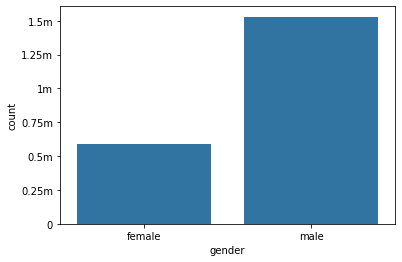

In [16]:
base_color = sb.color_palette()[0]
sb.countplot(data=df, x='gender', color=base_color)
plt.yticks([0, 0.25e6, 0.5e6, 0.75e6, 1e6, 1.25e6, 1.5e6], ['0', '0.25m', '0.5m', '0.75m', '1m', '1.25m', '1.5m']);

- **Conclusion:** First take away is that most of the dataset covering August 2019 is coming from male users with a more than 70% of the user population.

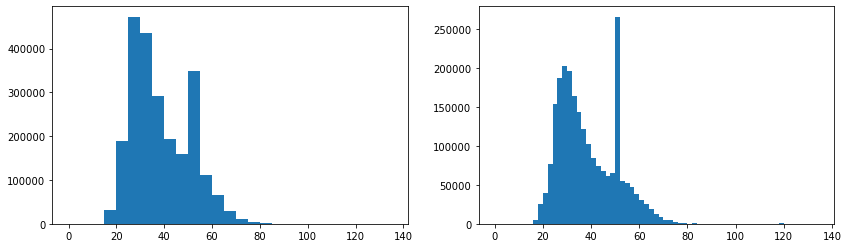

In [17]:
#having a look at the distribution of age
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
bins = np.arange(0, df['age'].max()+5, 5)
plt.hist(data=df, x='age', bins=bins);

plt.subplot(1, 2, 2)
bins = np.arange(0, df['age'].max()+2, 2)
plt.hist(data=df, x='age', bins=bins);

- **Conclusion:** Looks like the age distribution is bi modal at 2 peaks. First and highest, at the 25 to 30 age marks. second, at the 50 to 55 age marks.

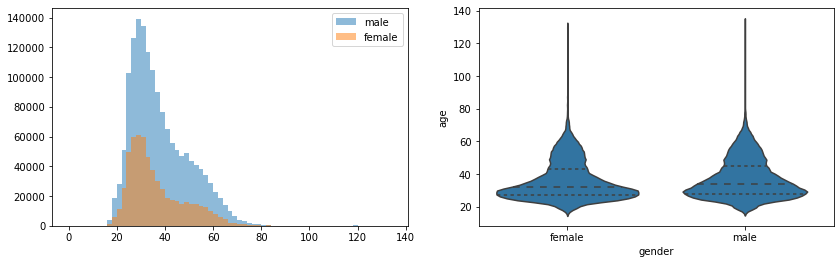

In [18]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
bins = np.arange(0, df['age'].max()+2, 2)
plt.hist(data=df[df.gender == 'male'], x='age', alpha=0.5, bins=bins)
plt.hist(data=df[df.gender == 'female'], x='age', alpha=0.5, bins=bins)
plt.legend(['male', 'female'])

plt.subplot(1, 2, 2)
base_color = sb.color_palette()[0]
sb.violinplot(data=df, x='gender', y='age', color=base_color, inner='quartile');

- **Conclusion:** Generally speaking, it looks like the ditribution of age between both genders is very similar. Moreover, between the 15-25 age marks, the distribution of gender is very close in absolute terms. The gap between males and females starts taking place at around 25 and widens even further around 45. <br>One thing to notice, however, is that the second modality at the 50 age mark point disappeared when looking at each of the genders alone. This might be attributable to the null values in the gender column. So let's test with this hypothesis in mind.

In [19]:
df[df.gender.isnull()].sample(10).iloc[:, 12:]

,usertype,birth year,gender,age
2018282,Customer,1969,NaN,50
2330443,Subscriber,1981,NaN,38
188493,Customer,1969,NaN,50
900942,Subscriber,1969,NaN,50
2302164,Customer,1969,NaN,50
1258838,Customer,1969,NaN,50
2229890,Subscriber,1969,NaN,50
754792,Customer,1969,NaN,50
1401986,Customer,1969,NaN,50
1517552,Subscriber,1969,NaN,50


In [20]:
df[df.gender.isnull()][df.usertype == 'Customer'].age.value_counts()

<ipython-input-20-ede54ba4b364>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.gender.isnull()][df.usertype == 'Customer'].age.value_counts()


50     188135
30        339
29        198
31        193
36        182
27        175
28        139
39        136
24        134
34        132
25        123
23        122
21        113
26        107
33        106
19        103
35        101
22         94
32         83
38         73
40         69
20         65
41         53
37         44
18         41
45         38
42         35
49         32
43         28
53         27
60         24
44         22
119        21
51         21
48         20
47         18
54         18
46         17
17         17
56         16
16         15
52         13
59         12
62         12
58          9
55          8
57          6
68          6
69          5
118         5
89          4
63          3
61          2
128         1
Name: age, dtype: int64

In [21]:
df[df.gender.isnull()][df.usertype == 'Subscriber'].age.value_counts()

<ipython-input-21-ce38572ba293>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df.gender.isnull()][df.usertype == 'Subscriber'].age.value_counts()


50    19503
30      950
29      830
31      749
39      718
      ...  
71        5
84        2
67        1
66        1
88        1
Name: age, Length: 65, dtype: int64

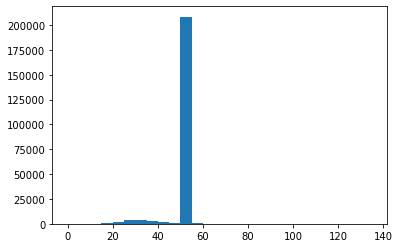

In [22]:
bins = np.arange(0, df['age'].max()+5, 5)
plt.hist(data=df[df.gender.isnull()], x='age', bins=bins);

- **Conclusion:** As expected, the bi modality in the age distribution is mostly due to the gendrless records which means that they could very well be defaulted to ease the data entry when age/gender are unavailable for the rental record. For the male and female entries, however, there is a slight decrease in the decreasing slope between the 45-60 age marks. Other than that, the bi modality at the 50 age mark should not factor into the final analysis results.

Now that we have covered the age and gender bahviors. Let's next look at the `usertype` column to try and combine it with the other variables.

In [23]:
df.usertype.value_counts(True)

Subscriber    0.810661
Customer      0.189339
Name: usertype, dtype: float64

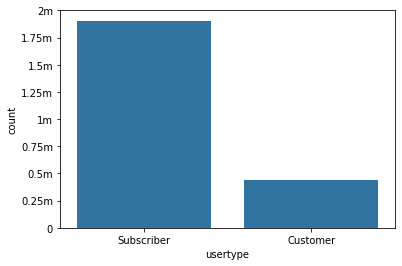

In [24]:
base_color = sb.color_palette()[0]
sb.countplot(data=df, x='usertype', color=base_color)
plt.yticks([0, 0.25e6, 0.5e6, 0.75e6, 1e6, 1.25e6, 1.5e6, 1.75e6, 2e6], ['0', '0.25m', '0.5m', '0.75m', '1m', '1.25m', '1.5m', '1.75m', '2m']);

- **Conclusion:** Most bike rentals are coming from subscribers with an 80% majority while the remaining 20% from customers.

In [25]:
sgender = df[df.usertype == 'Subscriber'].gender.value_counts(True).index
svalues = df[df.usertype == 'Subscriber'].gender.value_counts(True).values
cgender = df[df.usertype == 'Customer'].gender.value_counts(True).index
cvalues = df[df.usertype == 'Customer'].gender.value_counts(True).values

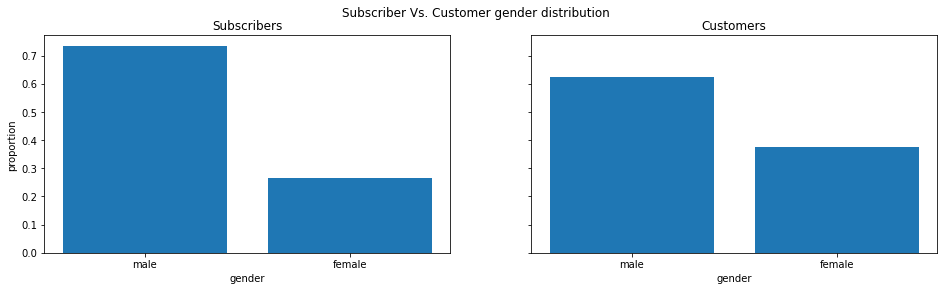

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[16, 4])
fig.suptitle('Subscriber Vs. Customer gender distribution')

ax1.bar(sgender, svalues)
ax1.set_title('Subscribers')
ax1.set(xlabel='gender', ylabel='proportion')

ax2.bar(cgender, cvalues)
ax2.set_title('Customers')
ax2.set(xlabel='gender');

- **Conclusion:** It looks like there is a bigger gap in the gender distribution of Subscribers with over 70% for males and less than 30% for females. For Customers, howevere, this gap is a little bit closer with 60% for males and 40% for females. For both genders, anyway, the male population is higher than females. 

<ipython-input-27-6da00f0b2228>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(data=df[~df.gender.isnull()][df.usertype == 'Subscriber'], x='age', alpha=0.5, bins=bins)
<ipython-input-27-6da00f0b2228>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.hist(data=df[~df.gender.isnull()][df.usertype == 'Customer'], x='age', alpha=0.5, bins=bins)


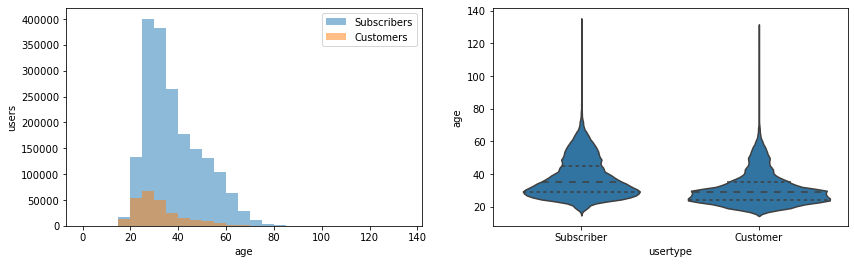

In [27]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 2, 1)
bins = np.arange(0, df['age'].max()+5, 5)
plt.hist(data=df[~df.gender.isnull()][df.usertype == 'Subscriber'], x='age', alpha=0.5, bins=bins)
plt.hist(data=df[~df.gender.isnull()][df.usertype == 'Customer'], x='age', alpha=0.5, bins=bins)
plt.legend(['Subscribers', 'Customers'])
plt.xlabel('age')
plt.ylabel('users')

plt.subplot(1, 2, 2)
base_color = sb.color_palette()[0]
sb.violinplot(data=df[~df.gender.isnull()], x='usertype', y='age', color=base_color, inner='quartile');

- **Conclusion:** It seems that more than 75% of the Customers are clustered below the 40 years age mark. Whereas for Subscribers, almost 50% of their population are over 40 year of age. the modal age for both distributions is similar however, that is between 25-30. 

<a id='2'></a>
### Question 2:  What are the most frequently used trips? Are they different for subscribers and customers?

To answer this question, we have to engineer a trip defined variable. Naturally, a trip could be defined by the starting and ending stations. This could be accomplished using stations IDs or names. Names should be more descriptive for the purpose of this analysis.

In [28]:
#concatinating station names
df['trip'] = df['start station name'] + ' - ' + df['end station name']
df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,age,trip
0,393,2019-08-01 00:00:01.4680,2019-08-01 00:06:35.3780,531.0,Forsyth St & Broome St,40.718939,-73.992663,408.0,Market St & Cherry St,40.710762,-73.994004,35305,Subscriber,1996,female,23,Forsyth St & Broome St - Market St & Cherry St
1,627,2019-08-01 00:00:01.9290,2019-08-01 00:10:29.7840,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,3409.0,Bergen St & Smith St,40.686744,-73.990632,38822,Subscriber,1998,female,21,Lafayette Ave & Fort Greene Pl - Bergen St & S...
2,1132,2019-08-01 00:00:04.0480,2019-08-01 00:18:56.1650,2000.0,Front St & Washington St,40.702551,-73.989402,3388.0,President St & Henry St,40.682800,-73.999904,18373,Subscriber,1988,male,31,Front St & Washington St - President St & Henr...
3,1780,2019-08-01 00:00:04.1630,2019-08-01 00:29:44.7940,479.0,9 Ave & W 45 St,40.760193,-73.991255,473.0,Rivington St & Chrystie St,40.721101,-73.991925,25002,Subscriber,1988,male,31,9 Ave & W 45 St - Rivington St & Chrystie St
4,1517,2019-08-01 00:00:05.4580,2019-08-01 00:25:23.4550,3312.0,1 Ave & E 94 St,40.781721,-73.945940,3312.0,1 Ave & E 94 St,40.781721,-73.945940,31198,Subscriber,1965,female,54,1 Ave & E 94 St - 1 Ave & E 94 St


In [29]:
#top 10 frequented trips
df.trip.value_counts()[:10]

Soissons Landing - Soissons Landing                1231
Soissons Landing - Picnic Point                    1086
Picnic Point - Soissons Landing                    1083
Central Park S & 6 Ave - Central Park S & 6 Ave     891
Yankee Ferry Terminal - Yankee Ferry Terminal       881
E 7 St & Avenue A - Cooper Square & Astor Pl        840
Central Park S & 6 Ave - 5 Ave & E 88 St            818
Yankee Ferry Terminal - Soissons Landing            810
Soissons Landing - Yankee Ferry Terminal            775
12 Ave & W 40 St - West St & Chambers St            703
Name: trip, dtype: int64

In [30]:
#top 10 frequented trips for subscribers
df[df.usertype == 'Subscriber'].trip.value_counts()[:10]

E 7 St & Avenue A - Cooper Square & Astor Pl                793
McGuinness Blvd & Eagle St - Vernon Blvd & 50 Ave           554
West Thames St - South End Ave & Liberty St                 536
Vesey Pl & River Terrace - North Moore St & Greenwich St    533
E 13 St & Avenue A - Broadway & E 14 St                     516
E 6 St & Avenue B - Cooper Square & Astor Pl                498
North Moore St & Greenwich St - Vesey Pl & River Terrace    494
Vernon Blvd & 50 Ave - McGuinness Blvd & Eagle St           494
N 6 St & Bedford Ave - S 4 St & Wythe Ave                   486
Pershing Square North - W 33 St & 7 Ave                     471
Name: trip, dtype: int64

In [31]:
##top 10 frequented trips for customers
df[df.usertype == 'Customer'].trip.value_counts()[:10]

Soissons Landing - Soissons Landing                                      881
Central Park S & 6 Ave - 5 Ave & E 88 St                                 746
Soissons Landing - Picnic Point                                          735
Picnic Point - Soissons Landing                                          688
Central Park S & 6 Ave - Central Park S & 6 Ave                          687
Yankee Ferry Terminal - Yankee Ferry Terminal                            612
Yankee Ferry Terminal - Soissons Landing                                 573
Grand Army Plaza & Central Park S - 5 Ave & E 88 St                      525
Soissons Landing - Yankee Ferry Terminal                                 515
Grand Army Plaza & Central Park S - Grand Army Plaza & Central Park S    490
Name: trip, dtype: int64

In [32]:
#ranking trips, bikeid is selected randomly to generate a count column
df_all = df.groupby(['trip'], as_index=False).bikeid.count()
df_all['general_rank'] = df_all.bikeid.rank(method='max', ascending=False)
df_all

,trip,bikeid,general_rank
0,1 Ave & E 110 St - 1 Ave & E 110 St,73,4820.0
1,1 Ave & E 110 St - 1 Ave & E 16 St,1,206448.0
2,1 Ave & E 110 St - 1 Ave & E 62 St,4,104097.0
3,1 Ave & E 110 St - 1 Ave & E 68 St,17,36392.0
4,1 Ave & E 110 St - 1 Ave & E 78 St,3,121938.0
...,...,...,...
206443,Yankee Ferry Terminal - South St & Gouverneur Ln,7,73823.0
206444,Yankee Ferry Terminal - South St & Whitehall St,31,19053.0
206445,Yankee Ferry Terminal - W 4 St & 7 Ave S,2,150356.0
206446,Yankee Ferry Terminal - Washington St & Gansev...,2,150356.0


In [33]:
#ranking trips for subscribers
df_sub = df[df.usertype == 'Subscriber'].groupby(['trip'], as_index=False).bikeid.count()
df_sub['sub_rank'] = df_sub.bikeid.rank(method='max', ascending=False)
df_sub

,trip,bikeid,sub_rank
0,1 Ave & E 110 St - 1 Ave & E 110 St,49,7341.0
1,1 Ave & E 110 St - 1 Ave & E 16 St,1,192038.0
2,1 Ave & E 110 St - 1 Ave & E 62 St,4,90676.0
3,1 Ave & E 110 St - 1 Ave & E 68 St,16,31894.0
4,1 Ave & E 110 St - 1 Ave & E 78 St,2,134623.0
...,...,...,...
192033,Yankee Ferry Terminal - Picnic Point,184,333.0
192034,Yankee Ferry Terminal - Soissons Landing,237,170.0
192035,Yankee Ferry Terminal - South St & Gouverneur Ln,1,192038.0
192036,Yankee Ferry Terminal - South St & Whitehall St,14,36213.0


In [34]:
#ranking trips for customers
df_cust = df[df.usertype == 'Customer'].groupby(['trip'], as_index=False).bikeid.count()
df_cust['cust_rank'] = df_cust.bikeid.rank(method='max', ascending=False)
df_cust

,trip,bikeid,cust_rank
0,1 Ave & E 110 St - 1 Ave & E 110 St,24,1802.0
1,1 Ave & E 110 St - 1 Ave & E 68 St,1,103916.0
2,1 Ave & E 110 St - 1 Ave & E 78 St,1,103916.0
3,1 Ave & E 110 St - 11 Ave & W 59 St,2,64565.0
4,1 Ave & E 110 St - 2 Ave & E 104 St,3,43371.0
...,...,...,...
103911,Yankee Ferry Terminal - South St & Gouverneur Ln,6,18648.0
103912,Yankee Ferry Terminal - South St & Whitehall St,17,3243.0
103913,Yankee Ferry Terminal - W 4 St & 7 Ave S,2,64565.0
103914,Yankee Ferry Terminal - Washington St & Gansev...,2,64565.0


In [35]:
#merging general rankings with subscribers and customer rankings
df_rank = df_all.merge(df_sub, how='left', left_on='trip', right_on='trip')
df_rank = df_rank.merge(df_cust, how='left', left_on='trip', right_on='trip')
df_rank = df_rank[['trip', 'general_rank', 'sub_rank', 'cust_rank']]
df_rank.sort_values('general_rank')[:25]

,trip,general_rank,sub_rank,cust_rank
162085,Soissons Landing - Soissons Landing,1.0,51.0,1.0
162084,Soissons Landing - Picnic Point,2.0,50.0,3.0
151300,Picnic Point - Soissons Landing,3.0,27.0,4.0
52180,Central Park S & 6 Ave - Central Park S & 6 Ave,4.0,247.0,5.0
206447,Yankee Ferry Terminal - Yankee Ferry Terminal,5.0,113.0,6.0
94774,E 7 St & Avenue A - Cooper Square & Astor Pl,6.0,1.0,629.0
52125,Central Park S & 6 Ave - 5 Ave & E 88 St,7.0,3455.0,2.0
206442,Yankee Ferry Terminal - Soissons Landing,8.0,170.0,7.0
162092,Soissons Landing - Yankee Ferry Terminal,9.0,127.0,9.0
5959,12 Ave & W 40 St - West St & Chambers St,10.0,30.0,26.0


- **Conclusion:** Even though the proportion of `customers` constitutes less than 20% of the dataset population, they are more effective in determining the top most frequented trips. When sorting the trips by the general ranking regardless of user types, there is a clear relation between the general rankings and `customer` rankings. This could simply be attributed to touristic which is in the monumental station names. For example, some trips share the same starting and ending stations which proves that the main reason for rentals is not transportations. This is very different for `subscribers` whose most frequented trips are not aligned with generic rankings. To put this into numbers, while there are only 4 top consective trips by `subscribers` that made it to the generic top 25 rankongs, the top 13 consecutive trips for `customers` are all present.<br><br>In other words, as presented below, the top 10 most frequented trips for `subscribers` are ranging between 629-3617 rankings for `customers`. Nevertheless, the top 10 most frequented trips for `customers` are ranging between 27-7618 rankings for `subscribers`. This in turn means that while the main purpose for customer rentals may be targeted at tourism, the purpose for subscriber rentals are varying between both tourims and general transportation while leaning to the latter.

In [36]:
df_rank.sort_values('sub_rank')[:10]

,trip,general_rank,sub_rank,cust_rank
94774,E 7 St & Avenue A - Cooper Square & Astor Pl,6.0,1.0,629.0
138014,McGuinness Blvd & Eagle St - Vernon Blvd & 50 Ave,13.0,2.0,1102.0
203563,West Thames St - South End Ave & Liberty St,20.0,3.0,1021.0
173676,Vesey Pl & River Terrace - North Moore St & Gr...,23.0,4.0,2674.0
74295,E 13 St & Avenue A - Broadway & E 14 St,26.0,5.0,1668.0
92578,E 6 St & Avenue B - Cooper Square & Astor Pl,25.0,6.0,642.0
173186,Vernon Blvd & 50 Ave - McGuinness Blvd & Eagle St,31.0,8.0,1937.0
146668,North Moore St & Greenwich St - Vesey Pl & Riv...,32.0,8.0,2938.0
144936,N 6 St & Bedford Ave - S 4 St & Wythe Ave,29.0,9.0,661.0
150820,Pershing Square North - W 33 St & 7 Ave,34.0,10.0,3617.0


In [37]:
df_rank.sort_values('cust_rank')[:10]

,trip,general_rank,sub_rank,cust_rank
162085,Soissons Landing - Soissons Landing,1.0,51.0,1.0
52125,Central Park S & 6 Ave - 5 Ave & E 88 St,7.0,3455.0,2.0
162084,Soissons Landing - Picnic Point,2.0,50.0,3.0
151300,Picnic Point - Soissons Landing,3.0,27.0,4.0
52180,Central Park S & 6 Ave - Central Park S & 6 Ave,4.0,247.0,5.0
206447,Yankee Ferry Terminal - Yankee Ferry Terminal,5.0,113.0,6.0
206442,Yankee Ferry Terminal - Soissons Landing,8.0,170.0,7.0
112327,Grand Army Plaza & Central Park S - 5 Ave & E ...,17.0,7618.0,8.0
162092,Soissons Landing - Yankee Ferry Terminal,9.0,127.0,9.0
112527,Grand Army Plaza & Central Park S - Grand Army...,12.0,1165.0,10.0


<a id='3'></a>
### Question 3: Take a look at the subscribers during working days of the week (Mo. - Fr.). Visualize the average number of rentals and returns per hour for the most frequently used stations. Can you interpret the result?

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344135 entries, 0 to 2344134
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   tripduration             int64  
 1   starttime                object 
 2   stoptime                 object 
 3   start station id         float64
 4   start station name       object 
 5   start station latitude   float64
 6   start station longitude  float64
 7   end station id           float64
 8   end station name         object 
 9   end station latitude     float64
 10  end station longitude    float64
 11  bikeid                   int64  
 12  usertype                 object 
 13  birth year               int64  
 14  gender                   object 
 15  age                      int64  
 16  trip                     object 
dtypes: float64(6), int64(4), object(7)
memory usage: 304.0+ MB


In [39]:
#converting data types of datetime variables
df['starttime'] = pd.to_datetime(df.starttime, yearfirst=True)
df['stoptime'] = pd.to_datetime(df.stoptime, yearfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2344135 entries, 0 to 2344134
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   tripduration             int64         
 1   starttime                datetime64[ns]
 2   stoptime                 datetime64[ns]
 3   start station id         float64       
 4   start station name       object        
 5   start station latitude   float64       
 6   start station longitude  float64       
 7   end station id           float64       
 8   end station name         object        
 9   end station latitude     float64       
 10  end station longitude    float64       
 11  bikeid                   int64         
 12  usertype                 object        
 13  birth year               int64         
 14  gender                   object        
 15  age                      int64         
 16  trip                     object        
dtypes: datetime64[ns](2), float

In [40]:
#creating name of day columns for both start dates and end dates
df['rentday'] = df.starttime.dt.day_name()
df['returnday'] = df.stoptime.dt.day_name()

#extracting hour columns for both start time and end time
df['renthour'] = df.starttime.dt.hour
df['returnhour'] = df.stoptime.dt.hour

#extracting date columns for both start date and end date
df['rentdate'] = df.starttime.dt.date
df['returndate'] = df.starttime.dt.date

df.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,birth year,gender,age,trip,rentday,returnday,renthour,returnhour,rentdate,returndate
0,393,2019-08-01 00:00:01.468,2019-08-01 00:06:35.378,531.0,Forsyth St & Broome St,40.718939,-73.992663,408.0,Market St & Cherry St,40.710762,...,1996,female,23,Forsyth St & Broome St - Market St & Cherry St,Thursday,Thursday,0,0,2019-08-01,2019-08-01
1,627,2019-08-01 00:00:01.929,2019-08-01 00:10:29.784,274.0,Lafayette Ave & Fort Greene Pl,40.686919,-73.976682,3409.0,Bergen St & Smith St,40.686744,...,1998,female,21,Lafayette Ave & Fort Greene Pl - Bergen St & S...,Thursday,Thursday,0,0,2019-08-01,2019-08-01
2,1132,2019-08-01 00:00:04.048,2019-08-01 00:18:56.165,2000.0,Front St & Washington St,40.702551,-73.989402,3388.0,President St & Henry St,40.682800,...,1988,male,31,Front St & Washington St - President St & Henr...,Thursday,Thursday,0,0,2019-08-01,2019-08-01
3,1780,2019-08-01 00:00:04.163,2019-08-01 00:29:44.794,479.0,9 Ave & W 45 St,40.760193,-73.991255,473.0,Rivington St & Chrystie St,40.721101,...,1988,male,31,9 Ave & W 45 St - Rivington St & Chrystie St,Thursday,Thursday,0,0,2019-08-01,2019-08-01
4,1517,2019-08-01 00:00:05.458,2019-08-01 00:25:23.455,3312.0,1 Ave & E 94 St,40.781721,-73.945940,3312.0,1 Ave & E 94 St,40.781721,...,1965,female,54,1 Ave & E 94 St - 1 Ave & E 94 St,Thursday,Thursday,0,0,2019-08-01,2019-08-01


In [41]:
#filtering for subscribers and assigning the focus columns into a new DataFrame
dfhour = df[df.usertype == 'Subscriber'][['start station name', 'end station name',
                                          'rentday', 'returnday',
                                          'renthour', 'returnhour',
                                          'rentdate', 'returndate']]
dfhour.sample(5)

,start station name,end station name,rentday,returnday,renthour,returnhour,rentdate,returndate
1547110,E 6 St & Avenue B,Grand St & Elizabeth St,Wednesday,Wednesday,8,8,2019-08-21,2019-08-21
529049,E 39 St & 3 Ave,E 20 St & 2 Ave,Wednesday,Wednesday,22,22,2019-08-07,2019-08-07
2095290,E 11 St & 1 Ave,University Pl & E 8 St,Wednesday,Wednesday,16,16,2019-08-28,2019-08-28
1066541,E 81 St & 2 Ave,Jackson St & Leonard St,Wednesday,Wednesday,19,20,2019-08-14,2019-08-14
909243,Grand Army Plaza & Central Park S,Watts St & Greenwich St,Monday,Monday,18,19,2019-08-12,2019-08-12


In [42]:
#melting 8 columns into 4 + type (extracting, renaming, and reappending)
dfhour_rent = dfhour[['start station name',
                      'rentday',
                      'renthour',
                      'rentdate']]
dfhour_rent.rename({'start station name': 'station', 'rentday': 'day',
                    'renthour': 'hour', 'rentdate': 'date'},
                   axis=1, inplace=True)
dfhour_rent['type'] = 'rent'


dfhour_return = dfhour[['end station name',
                      'returnday',
                      'returnhour',
                      'returndate']]
dfhour_return.rename({'end station name': 'station', 'returnday': 'day',
                      'returnhour': 'hour', 'returndate': 'date'},
                     axis=1, inplace=True)
dfhour_return['type'] = 'return'


dfhour = pd.concat([dfhour_rent, dfhour_return])
dfhour

/Users/hazemsamir/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-42-5919df82e015>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfhour_rent['type'] = 'rent'
<ipython-input-42-5919df82e015>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-

,station,day,hour,date,type
0,Forsyth St & Broome St,Thursday,0,2019-08-01,rent
1,Lafayette Ave & Fort Greene Pl,Thursday,0,2019-08-01,rent
2,Front St & Washington St,Thursday,0,2019-08-01,rent
3,9 Ave & W 45 St,Thursday,0,2019-08-01,rent
4,1 Ave & E 94 St,Thursday,0,2019-08-01,rent
...,...,...,...,...,...
2344127,Broadway & E 14 St,Sunday,0,2019-08-31,return
2344128,E 4 St & 2 Ave,Sunday,0,2019-08-31,return
2344130,9 Ave & W 22 St,Sunday,0,2019-08-31,return
2344131,S Portland Ave & Hanson Pl,Sunday,0,2019-08-31,return


In [43]:
dfhour.day.unique()

array(['Thursday', 'Friday', 'Saturday', 'Sunday', 'Monday', 'Tuesday',
       'Wednesday'], dtype=object)

In [44]:
#removing weekends
dfhour = dfhour[~dfhour.day.isin(['Saturday', 'Sunday'])]
dfhour.day.unique()

array(['Thursday', 'Friday', 'Monday', 'Tuesday', 'Wednesday'],
      dtype=object)

In [45]:
#grouping by to view count for rental/return per station/day/hour
dfhour = dfhour.groupby(['station', 'type', 'date', 'hour'], as_index=False).count()
dfhour.head()

,station,type,date,hour,day
0,1 Ave & E 110 St,rent,2019-08-01,0,1
1,1 Ave & E 110 St,rent,2019-08-01,4,1
2,1 Ave & E 110 St,rent,2019-08-01,5,2
3,1 Ave & E 110 St,rent,2019-08-01,6,3
4,1 Ave & E 110 St,rent,2019-08-01,7,5


In [46]:
dfhour.rename({'day': 'value'}, axis=1, inplace=True)
dfhour.head()

,station,type,date,hour,value
0,1 Ave & E 110 St,rent,2019-08-01,0,1
1,1 Ave & E 110 St,rent,2019-08-01,4,1
2,1 Ave & E 110 St,rent,2019-08-01,5,2
3,1 Ave & E 110 St,rent,2019-08-01,6,3
4,1 Ave & E 110 St,rent,2019-08-01,7,5


In [47]:
#to select the most frequented stations, let's focus on the top 10 percentile
start_top10percentile = np.percentile(df['start station name'].value_counts().values, q=90)
end_top10percentile = np.percentile(df['end station name'].value_counts().values, q=90)

In [49]:
x = df['start station name'].value_counts()
x = x[x > start_top10percentile].index

y = df['end station name'].value_counts()
y = y[y > end_top10percentile].index

In [50]:
top_stations = list(x) + list(y)
top_stations = pd.Series(top_stations).unique()
top_stations

array(['Pershing Square North', 'E 17 St & Broadway',
       'West St & Chambers St', '12 Ave & W 40 St', '8 Ave & W 31 St',
       'W 21 St & 6 Ave', 'Broadway & E 14 St',
       'Christopher St & Greenwich St', 'Broadway & W 60 St',
       'Broadway & E 22 St', 'W 20 St & 11 Ave', 'E 24 St & Park Ave S',
       'Lafayette St & E 8 St', 'South End Ave & Liberty St',
       'Cleveland Pl & Spring St', 'Grand Army Plaza & Central Park S',
       '6 Ave & W 33 St', 'W 41 St & 8 Ave', 'Broadway & W 25 St',
       'Carmine St & 6 Ave', '8 Ave & W 33 St',
       'Pier 40 - Hudson River Park', 'Central Park S & 6 Ave',
       'W 18 St & 6 Ave', 'W 34 St & 11 Ave', 'Grand St & Elizabeth St',
       'Greenwich Ave & 8 Ave', 'E 13 St & Avenue A',
       'Vesey Pl & River Terrace', 'W 38 St & 8 Ave',
       'Broadway & W 41 St', 'Washington St & Gansevoort St',
       '1 Ave & E 16 St', 'Centre St & Chambers St',
       'North Moore St & Greenwich St', 'Cooper Square & Astor Pl',
       'W 33 St

In [51]:
#reassigning DataFrame to the most frequented stations only
dfhour = dfhour[dfhour.station.isin(top_stations)]

In [52]:
#grouping by to calculate the daily average of rentals/returns per station/hour
dfhour = dfhour.groupby(['type', 'station', 'hour'], as_index=False)['value'].mean()
dfhour.head()

,type,station,hour,value
0,rent,1 Ave & E 16 St,0,3.095238
1,rent,1 Ave & E 16 St,1,1.800000
2,rent,1 Ave & E 16 St,2,1.375000
3,rent,1 Ave & E 16 St,3,1.500000
4,rent,1 Ave & E 16 St,4,1.894737


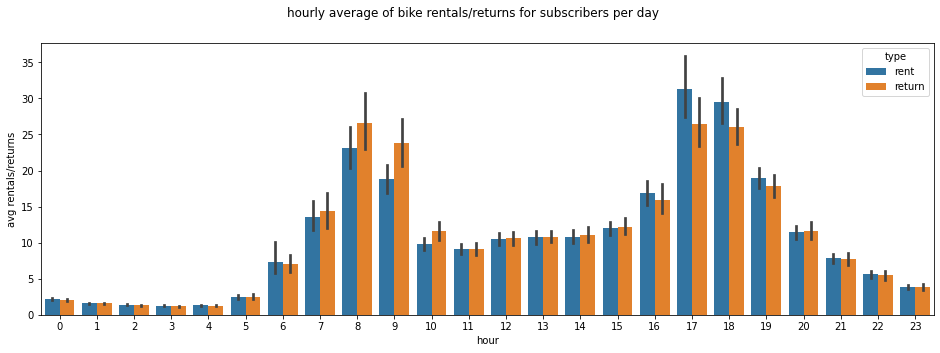

In [53]:
plt.figure(figsize=(16,5))

sb.barplot(data=dfhour, x='hour', y='value', hue='type')
plt.ylabel('avg rentals/returns')
plt.suptitle('hourly average of bike rentals/returns for subscribers per day');

*Disclaimer: Based on the top 10 percentile of the most frequented stations during working days of the week.*<br><br><br>

- **Conclusion:** To start with, most bike rentals/returns occur around 8-9 am or 5-6 pm. This, of course, makes perfect sense for working days of the week especially when looking at subscribers only. Starting at 6 am, both rentals and returns start increasing dramatically till it reaches the first peak at 8-9 am with an average of 25 rentals/returns a day. The trend then goes down to an average of 12 rentals/returns between 10 am to 3 pm. The trend starts picking up again at 4 pm to hit the second peak around 5-6 pm with an average of 25-30 rentals/returns. Starts descending again at 7 pm till it reaches mayeb 1 or 2 rentals/returns after midnight.<br>An additional thing to notice is that between 7 am to 3 pm, the returns are mostly higher than the rentals. Between 4 pm to 6 am, however, the rentals are higher than the returns. Again, this makes sense users might be inclined to rent bikes after their working hours and return it in morning before the next working day.

***